# Preprocessing

In [1]:
# Import all packages here
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df_3vac1 = pd.read_csv('../fbc/3VAC1.csv')

In [3]:
# Amplitude data is stored as string. Changing it to list of integers and storing in original column

def change_to_list(row):
    amplitudes_string = row['amplitudes'][1:-1]
    amplitude_list = amplitudes_string.split(',')

    map_object = map(int, amplitude_list)
    amplitude_list_int = list(map_object)

    return amplitude_list_int

df_3vac1['amplitudes'] = df_3vac1.apply(lambda x: change_to_list(x), axis=1)

In [4]:
# We only want device_id and amplitudes
# Calculate the Hz span of FBC Sweep before dropping column
# Also calculate the Amplitude array length - to be used later to calculate characteristics for notch/suckout

WAVE_FIRST = df_3vac1['first'][0]
WAVE_LAST = df_3vac1['last'][0]
WAVE_SPAN = WAVE_LAST - WAVE_FIRST
AMPLITUDE_LEN = len(df_3vac1['amplitudes'][0])

df_3vac1 = df_3vac1[['device_id','amplitudes']]

In [5]:
# We have to detect 3 kinds of wave deformities:
# (a) Noise Levels in the spectrum that go above 0 db
# (b) Noise Ingress
# (c) Notches/Suckouts

# Let us start with the first one...

# Above 0 db Noise

In [6]:
# Parameters:
# NOISE_WINDOW 
# NOISE_THRESHOLD

# Any waveform data point going above 0 does not necessarily indicate presence of above 0 db noise. It 
# could just be random white noise. That is not the kind of noise spike we are interested in. We need 
# to detect noise that is above a certain threshold, say 5 db (500 points along y axis) and sustains for a window, say 30 data points

NOISE_WINDOW = 30
NOISE_THRESHOLD = 500

def detect_above_0db_noise(data):
    amps = data
    detected_flag = 0
    
    # if the list contains any member above given THRESHOLD, only then check through iterative sliding windows
    if (any([amp_data_point >= NOISE_THRESHOLD for amp_data_point in amps])):
        for i in np.arange(0,len(amps),1):
            window = []
            for j in np.arange(0,NOISE_WINDOW,1):
                if (i+j < len(amps)):
                    window.append(amps[i+j])

            for window_item in window:
                if (window_item >= NOISE_THRESHOLD):
                    detected_flag = 1
                    break

    return detected_flag
    
df_3vac1['above_0db_noise_detected'] = df_3vac1['amplitudes'].progress_apply(lambda x: detect_above_0db_noise(x))

  0%|          | 0/1046 [00:00<?, ?it/s]

# Ingress

In [7]:
# Approach:
# (1) Filter in segments only from the FM band from the entire spectrum such that:
#     FM_band_lower_limit <= FM_band <= FM_band_upper_limit + num_samples_to_consider_to_the_right
#
#     The reason we are taking {num_samples_to_consider_to_the_right} is because ingress is most likely to be found 
#     as we are exiting this band / transitioning away from the FM band in the frequency spectrum
#
# (2) In these segments,
#     Check if there is a noise spike in the first few samples. If yes, declare ingress detected
#
# (3) If more than 80% data points in the node have ingress, then it is not of concern and we can declare it as not
#     detected because it creates no issue. If on the other hand, less than 80% data points do not show ingress, we 
#     have to leave the detected ingresses as is, for later use in clustering

In [34]:
# FM Band in the USA : 88 MHz to 108 MHz ()

# NUM_SAMPLES_TO_THE_RIGHT = Number of points we are considering to the right of the FM band for detection 
# of ingress spike
#
# AMPLITUDE_LEN (8704) points are present in the WAVE_SPAN
# This WAVE_SPAN houses the spectrum WAVE_FIRST (36 MHz) to WAVE_LAST (996 MHz)
# This is represented by the NUM_POINTS_IN_FM_BAND = (108 - 88)/WAVE_SPAN * AMPLITUDE_LEN + NUM_SAMPLES_TO_THE_LEFT
# STARTING_POINT_OF_ARRAY = (88 - WAVE_FIRST)/WAVE_SPAN * AMPLITUDE_LEN - NUM_SAMPLES_TO_THE_LEFT

NUM_SAMPLES_TO_THE_RIGHT = 600
NUM_POINTS_IN_FM_BAND = int(np.ceil(((108000000 - 88000000)/WAVE_SPAN * AMPLITUDE_LEN) + NUM_SAMPLES_TO_THE_RIGHT))
STARTING_POINT_OF_ARRAY = int(np.ceil(((88000000 - WAVE_FIRST)/WAVE_SPAN * AMPLITUDE_LEN)))
END_POINT_OF_ARRAY = STARTING_POINT_OF_ARRAY + NUM_POINTS_IN_FM_BAND

def plot_amps(amps):
    plt.figure(figsize=(17,5))
    plt.plot(amps, color='darkorange')
    plt.ylim(-8000,1000)
    plt.show()
    
# Params
# SMOOTHING_WINDOW_LENGTH - the window of moving averages

SMOOTHING_WINDOW_LENGTH = 50

def smoothen_waveform(data, window_size, diagnostics=False):
    numbers = data

    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    y = moving_averages
    x = [*range(len(y))]
    
    if diagnostics == False:
        return y
    
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    ax.scatter(x, y, s=1)
    ax.set_ylabel("Amplitude")
    plt.show()
    
    return y

# Params
# MINIMUM_SPIKE_HEIGHT - the noise spike must at least be of this height to be considered noise ingress
# MIN_DIST_THRESHOLD_FOR_INGRESS_DETECTION - minimum dtw distance metric to declare ingress detection

MINIMUM_SPIKE_HEIGHT = 4000
MIN_DIST_THRESHOLD_FOR_INGRESS_DETECTION = 60000

def match_candidate_against_ingress_template(amps, diagnostics = False):
    fm_ingress_detected = 0
    
    # define ingress template
    part_1 = list(np.arange(0,MINIMUM_SPIKE_HEIGHT+400,250))
    part_2 = list(np.arange(MINIMUM_SPIKE_HEIGHT+400,0,-250))
    part_3 = list(np.arange(0,MINIMUM_SPIKE_HEIGHT,250))
    part_4 = [MINIMUM_SPIKE_HEIGHT]*50
    y_points = part_1 + part_2 + part_3 + part_4

    ingress_template = y_points

    s1 = amps
    s2 = np.array(ingress_template, dtype=np.double)
    distance_score = dtw.distance(s1, s2)

    if (diagnostics == True):
        print(distance_score)
        path = dtw.warping_path(s1, s2)
        dtwvis.plot_warping(s1, s2, path)

    if(distance_score <= MIN_DIST_THRESHOLD_FOR_INGRESS_DETECTION):
        fm_ingress_detected = 1

    return fm_ingress_detected
    
def detect_fm_ingress(data, diagnostics = False):
    fm_ingress_detected = 0
    
    amps = data
    amps = amps[STARTING_POINT_OF_ARRAY:END_POINT_OF_ARRAY]
    smoothed_amps = smoothen_waveform(amps, 10)
    
    min_spike_amplitude = min(smoothed_amps) + MINIMUM_SPIKE_HEIGHT
    
    if (any([amp_data_point >= min_spike_amplitude for amp_data_point in smoothed_amps])):

        # consider only higher points 
        higher_smoothed_amps = []
        mean_smoothed_amps = np.mean(smoothed_amps)
        stddev_smoothed_amps = np.std(smoothed_amps)
        for i in np.arange(0,len(smoothed_amps),1):
            if (smoothed_amps[i] >= mean_smoothed_amps - 0.5*stddev_smoothed_amps):
                higher_smoothed_amps.append(smoothed_amps[i])
        higher_smoothed_amps = higher_smoothed_amps[0:150] # eliminate useless points to the right
        
        fm_ingress_detected = match_candidate_against_ingress_template(higher_smoothed_amps, diagnostics)
        
    else:
        return fm_ingress_detected
    
    return fm_ingress_detected

#### Few manual testcases

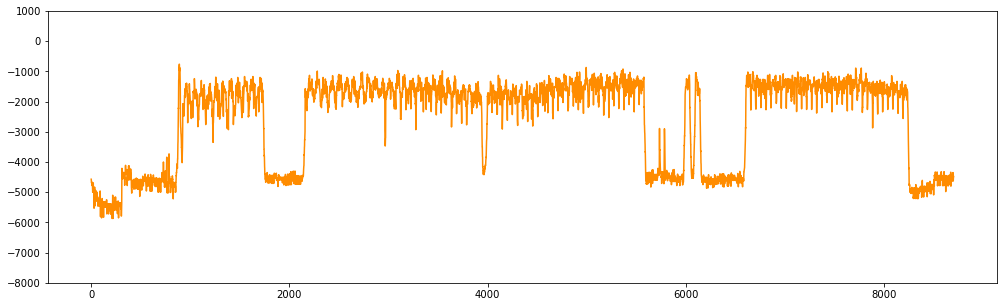

54337.294292226215


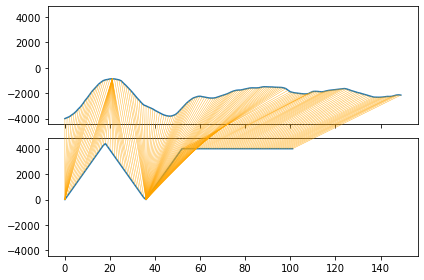

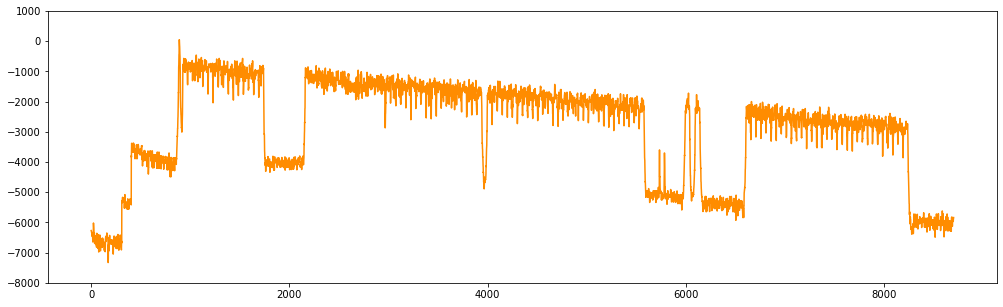

42977.222257842586


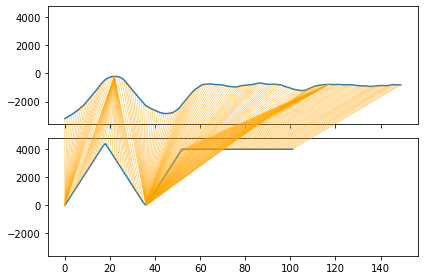

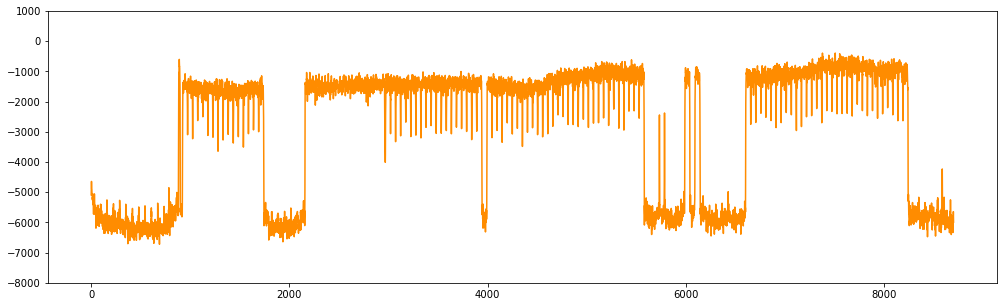

51162.41320969917


1

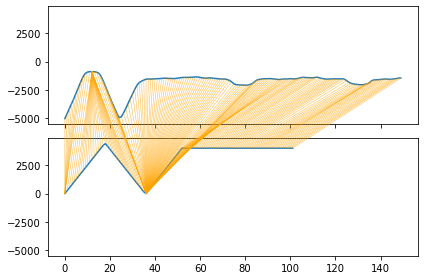

In [35]:
plot_amps(df_3vac1['amplitudes'][3])
detect_fm_ingress(df_3vac1['amplitudes'][3], True)

plot_amps(df_3vac1['amplitudes'][20])
detect_fm_ingress(df_3vac1['amplitudes'][20], True)

plot_amps(df_3vac1['amplitudes'][23])
detect_fm_ingress(df_3vac1['amplitudes'][23], True)

In [36]:
# seems to be working
# applying to entire dataset...

In [37]:
df_3vac1['ingress_detected'] = df_3vac1['amplitudes'].progress_apply(lambda x: detect_fm_ingress(x))

# now if ingress is detected in more than 80% rows, it is not useful, so we will set it back to 0
if (len(df_3vac1[df_3vac1['ingress_detected'] == 1]) > 0.8*len(df_3vac1)):
    df_3vac1 = df_3vac1.drop('ingress_detected', axis=1)
    df_3vac1['ingress_detected'] = [0]*len(df_3vac1)

  0%|          | 0/1046 [00:00<?, ?it/s]

# Notches/Suckouts

In [12]:
# This is a much harder problem, as the notches have a general V-shape dip, so it using a Euclidean matching filter
# against the given waveform is not very practical as we do not have a template to match against, since this general
# V-shape dip could be shallow/deeper, could be extended or compressed against the X-axis. So we do not have one 
# exact shape to match against, but rather we have to consider a continuum of shapes

# Approach:
# (1) First, smoothen the overall spectral data
#
# (2) Then, find segments in the wave where there are sudden dips
#
#     Approach to Detect:
#       Consider the median values in the segment. If there is a datapoint that goes significantly below the mean,
#       we can declare a dip.   
#
# (3) Iterate across all these windows and check if the dip is sudden, sharp and sustains for a very few data points
#
#     Approach to check whether the dip is a sharp noise spike:
#       If the dip sustains for a very few data points (the length of this window can be set as a parameter),
#       we declare this as a noise spike
#       
#     If yes, these are to be discarded, as these are noise spikes and do not represent a V-shaped dip
#
# (4) If no, we need further investigation to check if this is indeed a V-shaped dip that represents a notch
#      
#     Once sudden noise spike dips are discarded, we can smoothen the wave again (needed - yes/no?)
#    
#     Approach to detect V-shaped notch:
#       Create a sliding window template that is V-shaped. The characteristics of a notch is that the dip 
#       must be at least 5db, and for asuchout, it must be ~20db. In both cases, the dip must sustain for a 
#       window of at least 6-12 MHz. Do dtw matching of sliding window with given wave, and store the best distance
#       score for each wave. If this distance score is lower than a certain threshold (parameter that can be set)
#       we can declare that a notch/suckout has been detected. 

#### Detect All Dip Segments

In [13]:
# Since notch amplitude < suckout amplitude, we consider any dip that qualifies as a candidate notch and add them to
# the list of dips detected
MIN_DIP_FOR_VALID_NOTCH = 300

def detect_all_dip_segments(data, diagnostics=False):
    amps = data
    
    smoothed_amps = smoothen_waveform(data, SMOOTHING_WINDOW_LENGTH, diagnostics)
    median_smoothed_amp = np.median(smoothed_amps)
    stddev_smoothed_amp = np.std(smoothed_amps)
    
    flatband_segments_list = []
    flatband_segment_list = []
    for i in np.arange(0,len(smoothed_amps),1):
        if (smoothed_amps[i] >= median_smoothed_amp):
            if ((i+1 < len(smoothed_amps)) and (smoothed_amps[i+1] >= median_smoothed_amp)):
                flatband_segment_list.append(smoothed_amps[i])
            else:
                if (len(flatband_segment_list) != 0):
                    flatband_segments_list.append(flatband_segment_list)
                flatband_segment_list = []
    
    flatband_concat = list(np.concatenate(flatband_segments_list).flat)
    
    flatband_mean = np.mean(flatband_concat)
    
    # Anything that dips below MIN_DIP_FOR_VALID_NOTCH amplitude below the flatband mean is considered a valid dip
    # and added to dip_segments_list
    dip_segments_list = []   
    dip_segment_list = []
    for i in np.arange(0,len(smoothed_amps),1):
        if (smoothed_amps[i] <= (flatband_mean - MIN_DIP_FOR_VALID_NOTCH)):
            if ((i+1 < len(smoothed_amps)) and (smoothed_amps[i+1] <= (flatband_mean - MIN_DIP_FOR_VALID_NOTCH))):
                dip_segment_list.append(smoothed_amps[i])
            else:
                if(len(dip_segment_list) != 0):
                    dip_segments_list.append(dip_segment_list)
                dip_segment_list = []
    
    if (diagnostics == True):
        for segment in dip_segments_list:
            plt.plot(segment, color=np.random.rand(3,))
    
        print(len(dip_segments_list))
        for segment in dip_segments_list:
            print(len(segment))
            plt.plot(segment)
            plt.show()

    return dip_segments_list

#### Discard Noise Spikes and Detect Valid Notch/Suckout candidates

In [14]:
# Params
# MIN_WINDOW_LENGTH_FOR_VALID_DIP - if the length of the dip is lower than this minimum parameter, we consider it 
# as a noise spike and discard it

# Calculating required window length:
# AMPLITUDE_LEN array length holds data for WAVE_SPAN spectral span
# So, a window of at least 6 MHz should have AMPLITUDE_LEN/WAVE_SPAN * 6,000,000 points in the array

# MIN_DIP_FOR_VALID_NOTCH = 4db = 400 points along y axis - already defined above
# MIN_DIP_FOR_VALID_SUCKOUT = 20db = 2000 points along y axis
MIN_DIP_FOR_VALID_NOTCH = MIN_DIP_FOR_VALID_NOTCH
MIN_DIP_FOR_VALID_SUCKOUT = 2000
#MIN_HZ_WINDOW_FOR_VALID_NOTCH = 6000000

MIN_WINDOW_LENGTH_FOR_VALID_DIP = 200
#MIN_WINDOW_LENGTH_FOR_VALID_DIP = np.ceil(AMPLITUDE_LEN/WAVE_SPAN * MIN_HZ_WINDOW_FOR_VALID_NOTCH)

def extra_noise_spikes_filtering(dip_segments_list):
    new_dip_segments_list = []
    for segment in dip_segments_list:
        new_dip_segment = []
        median = np.median(segment)
        stddev = np.std(segment)
        
        for data_point in segment:
            if (data_point <= median + stddev and data_point >= median - stddev):
                new_dip_segment.append(data_point)
        new_dip_segments_list.append(new_dip_segment)

    return new_dip_segments_list
    
def detect_candidate_dips_from_dip_segments(data, min_window_length_for_valid_dip, diagnostics=False):
    amps = data
    
    # eliminate 1st 1000 data points in the part of the spectrum which is not meaningful for dip detection
    amps = amps[1000:]
    
    dip_segments_list = detect_all_dip_segments(amps, diagnostics)
    type_detected = ['None']*len(dip_segments_list)
    
    # eliminating lists from dip_segments_list which have less than {min_window_length_for_valid_dip} data points 
    # (noise spikes)
    
    dip_segments_list = extra_noise_spikes_filtering(dip_segments_list)
    dip_segments_list = [x for x in dip_segments_list if len(x) >= min_window_length_for_valid_dip]
    
    # if there are valid dip segments detected, check if the dip is significant enough to declare a notch/suckout
    dip_amplitudes_list = []
    if (len(dip_segments_list) != 0):
        for dip_segment in dip_segments_list:
            start_value_of_segment = dip_segment[0]
            min_value_of_segment = min(dip_segment)
            
            dip_amplitude = start_value_of_segment - min_value_of_segment
            dip_amplitudes_list.append(dip_amplitude)
    
    max_dip_amplitude = max(dip_amplitudes_list)
    potential_notch_or_suckout = 0
    if (max_dip_amplitude >= MIN_DIP_FOR_VALID_NOTCH):
        potential_notch_or_suckout = 1
    
    return dip_segments_list, max_dip_amplitude, potential_notch_or_suckout

In [15]:
# Params
MIN_DIST_THRESHOLD_FOR_NOTCH_DETECTION = 45000
MIN_DIST_THRESHOLD_FOR_SUCKOUT_DETECTION = 45000             

def match_candidate_dips_against_template(data, min_window_length_for_valid_dip, diagnostics=False):
    amps = data
    notch_detected = 0
    suckout_detected = 0
    notch_or_suckout_detected = 0
    
    dip_segments_list, max_dip_amplitude, potential_notch_or_suckout = detect_candidate_dips_from_dip_segments(amps,
                                                                                min_window_length_for_valid_dip,
                                                                                diagnostics)
    
    if (diagnostics == True):
        print(len(dip_segments_list))
        print("potential_notch_or_suckout = {}".format(potential_notch_or_suckout))
        
        for segment in dip_segments_list:
            print(len(segment))
            plt.plot(segment)
            plt.show()        
    
    if (potential_notch_or_suckout == 1):
        if (max_dip_amplitude >= MIN_DIP_FOR_VALID_NOTCH): 

                # define v-shape notch window
                left_half = list(np.arange(MIN_DIP_FOR_VALID_NOTCH,0,-1))
                right_half = list(np.arange(0,MIN_DIP_FOR_VALID_NOTCH,1))
                y_points = left_half + right_half 

                notch_window_template = y_points

                dtw_distance_scores = []
                for segment in dip_segments_list:
                    s1 = np.array(segment, dtype=np.double)
                    s2 = np.array(notch_window_template, dtype=np.double)
                    distance_score = dtw.distance(s1, s2)
                    dtw_distance_scores.append(distance_score)

                    if (diagnostics == True):
                        path = dtw.warping_path(segment, notch_window_template)
                        dtwvis.plot_warping(segment, notch_window_template, path)

                if (diagnostics == True):
                    print(dtw_distance_scores)

                for dist in dtw_distance_scores:
                    if(dist <= MIN_DIST_THRESHOLD_FOR_NOTCH_DETECTION):
                        notch_detected = 1
                        break
                
                # if notch is not detected, only then check for suckouts
                if (notch_detected == 0):

                    # if notch is not detected, first check if the max_dip_amplitude is big enough to check for suckouts

                    if (max_dip_amplitude >= MIN_DIP_FOR_VALID_SUCKOUT):
                        # define v-shape suckout window
                        left_half = list(np.arange(MIN_DIP_FOR_VALID_SUCKOUT,0,-1))
                        right_half = list(np.arange(0,MIN_DIP_FOR_VALID_SUCKOUT,1))
                        y_points = left_half + right_half 

                        suckout_window_template = y_points

                        dtw_distance_scores = []
                        for segment in dip_segments_list:
                            s1 = np.array(segment, dtype=np.double)
                            s2 = np.array(suckout_window_template, dtype=np.double)
                            distance_score = dtw.distance(s1, s2)
                            dtw_distance_scores.append(distance_score)

                            if (diagnostics == True):
                                path = dtw.warping_path(segment, suckout_window_template)
                                dtwvis.plot_warping(segment, suckout_window_template, path)

                        if (diagnostics == True):
                            print(dtw_distance_scores)

                        for dist in dtw_distance_scores:
                            if(dist <= MIN_DIST_THRESHOLD_FOR_SUCKOUT_DETECTION):
                                suckout_detected = 1
                                break
                                        
            
    notch_or_suckout_detected = notch_detected or suckout_detected
    return notch_or_suckout_detected

#### Few manual test cases

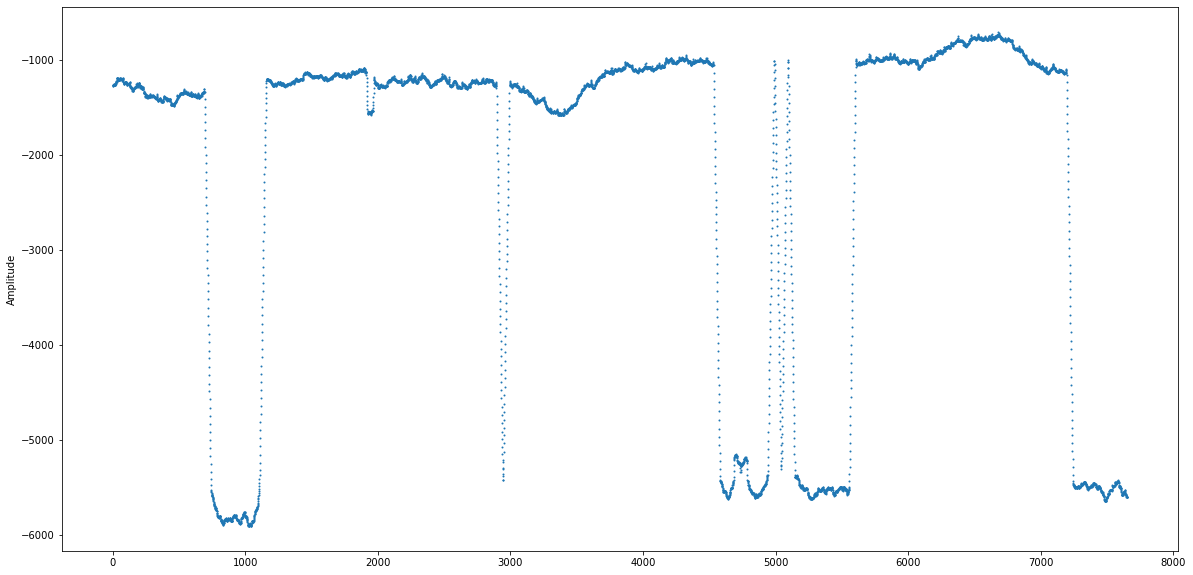

19
37


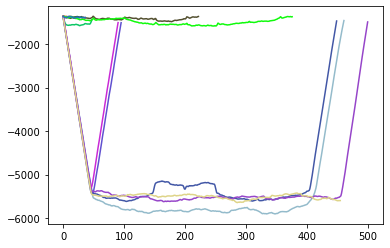

223


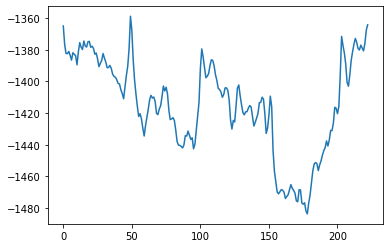

1


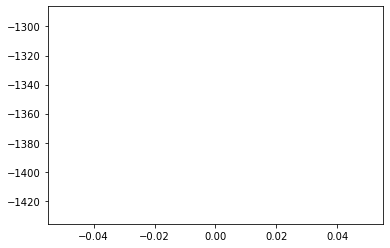

2


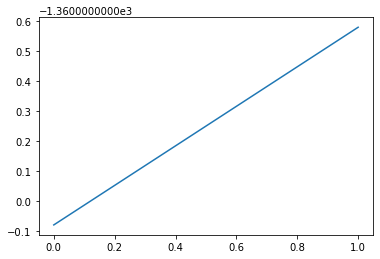

1


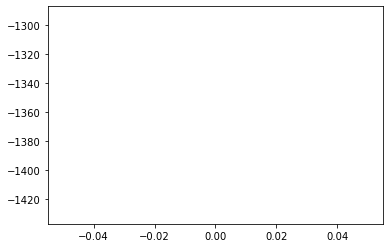

3


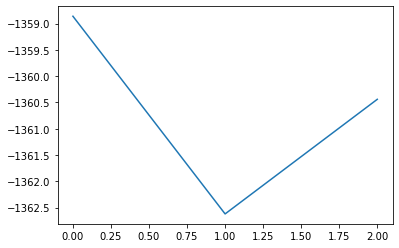

10


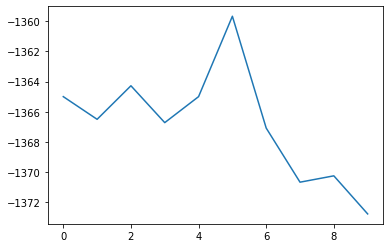

16


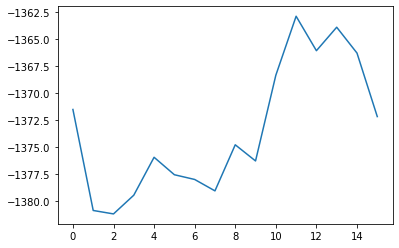

29


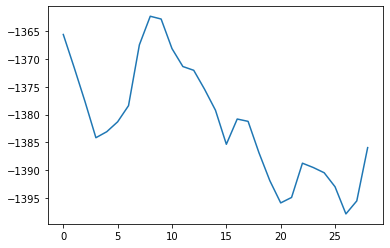

31


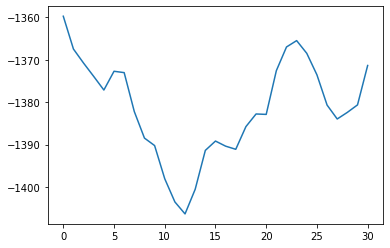

462


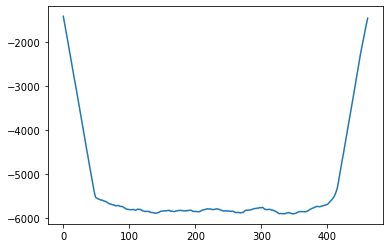

48


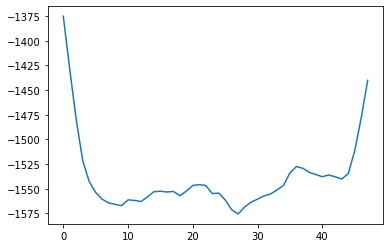

96


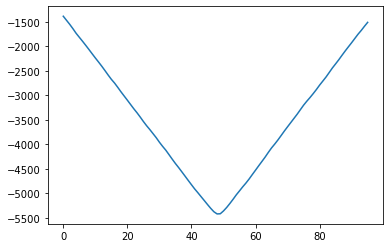

7


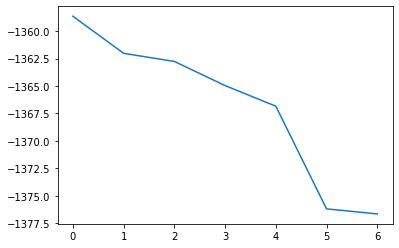

377


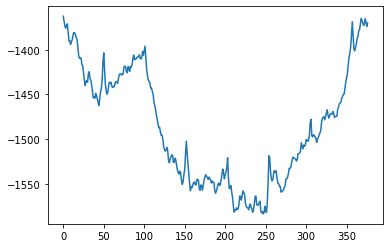

450


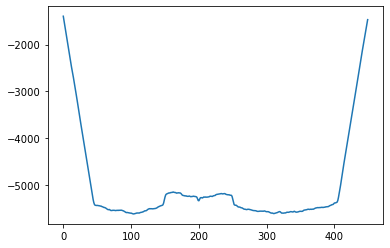

91


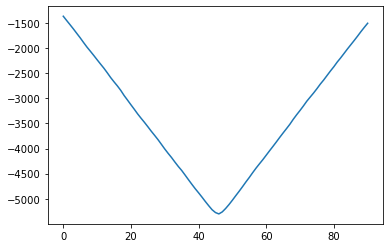

501


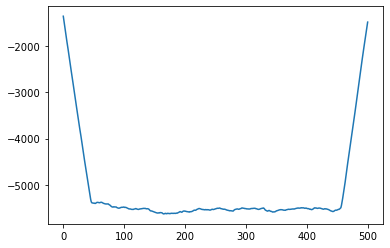

456


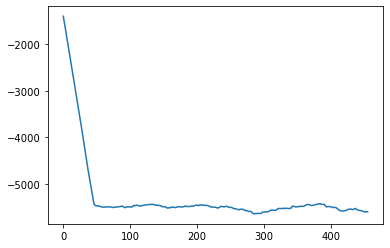

5
potential_notch_or_suckout = 1
384


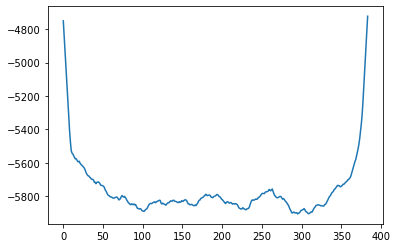

240


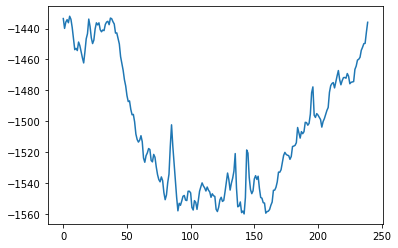

380


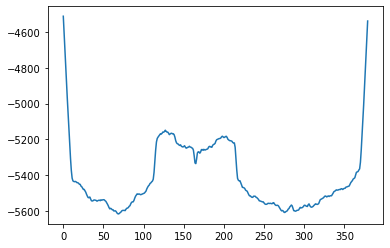

430


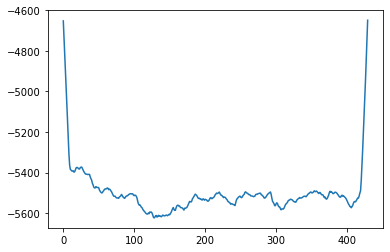

418


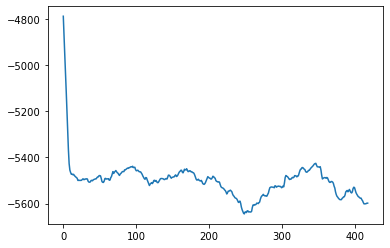

[136180.16184829862, 39514.20339428343, 128609.32991986701, 132755.19652931407, 133323.85933255905]


1

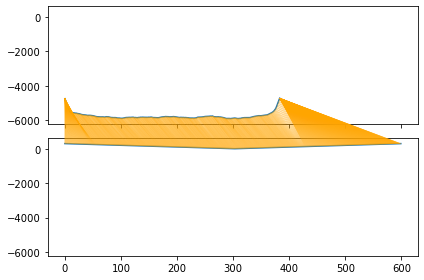

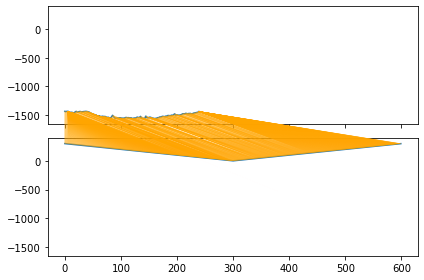

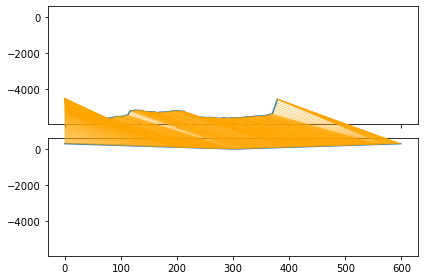

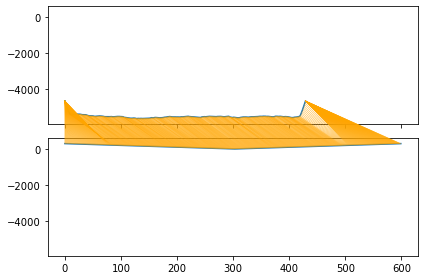

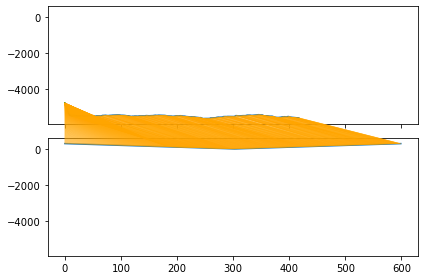

In [16]:
match_candidate_dips_against_template(df_3vac1.iloc[9]['amplitudes'], MIN_WINDOW_LENGTH_FOR_VALID_DIP, True)

In [17]:
df_3vac1_60 = df_3vac1.iloc[0:60].copy()
df_3vac1_60['notches_or_suckouts_detected'] = df_3vac1_60['amplitudes'].progress_apply(lambda x: match_candidate_dips_against_template(x, MIN_WINDOW_LENGTH_FOR_VALID_DIP), False)
df_3vac1_60_det = df_3vac1_60[df_3vac1_60['notches_or_suckouts_detected'] == 1]

  0%|          | 0/60 [00:00<?, ?it/s]

In [18]:
df_3vac1_60_det

,device_id,amplitudes,above_0db_noise_detected,ingress_detected,notches_or_suckouts_detected
6,fc:51:a4:76:ac:e4,"[-4660, -4670, -4850, -4920, -4920, -5000, -50...",0,0,1
9,98:f7:d7:b8:db:01,"[-5558, -5277, -5332, -5337, -5599, -5385, -52...",0,1,1
23,7c:26:34:76:d8:3a,"[-5089, -4993, -4801, -4644, -4846, -4885, -49...",0,1,1
35,bc:64:4b:f2:39:03,"[-5792, -5975, -6008, -5815, -5819, -5665, -60...",0,1,1
36,78:23:ae:1f:fe:ec,"[-4150, -4170, -4380, -4470, -4470, -4480, -44...",1,1,1
42,b0:da:f9:5c:b9:dc,"[-4860, -4880, -4520, -4430, -4430, -4740, -47...",0,1,1
52,90:58:51:f9:b7:a0,"[-1274, -1297, -1102, -1134, -1000, -1146, -11...",1,1,1
55,44:1c:12:52:51:c9,"[-1527, -1290, -1213, -1339, -1167, -975, -113...",0,1,1
56,fc:51:a4:76:ac:e4,"[-4370, -4390, -4370, -4350, -4350, -4630, -46...",0,0,1
58,f8:5e:42:8c:db:78,"[-1639, -1218, -1178, -1428, -1636, -1137, -11...",0,1,1


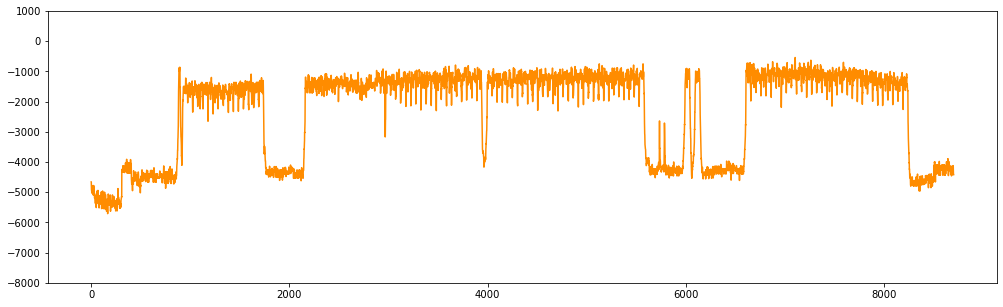

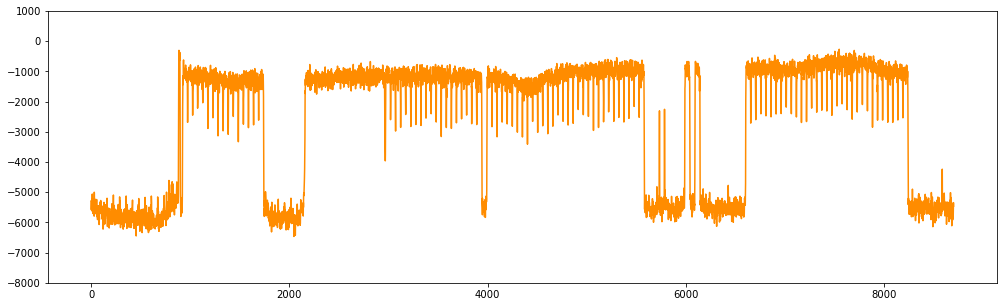

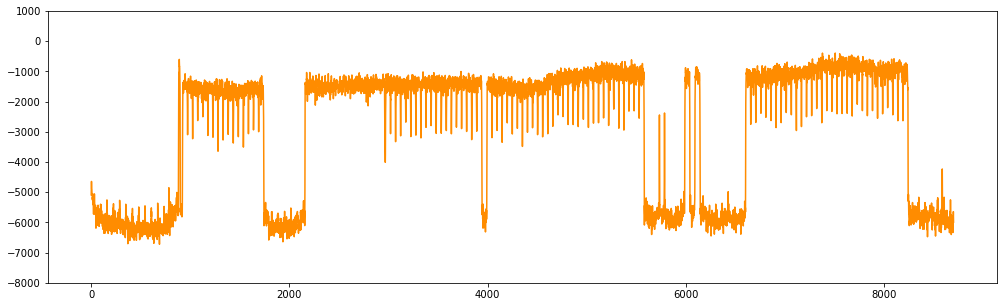

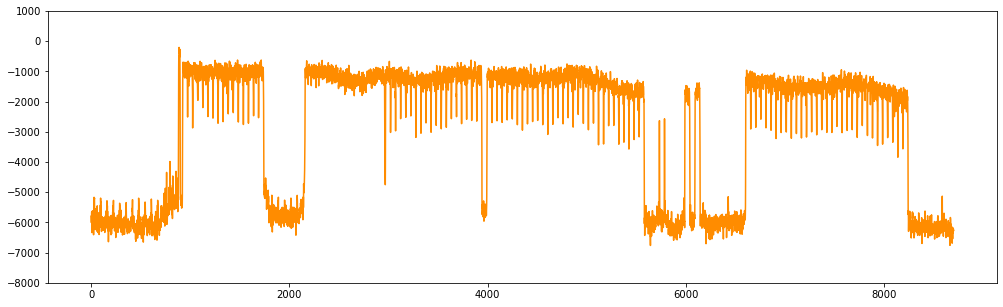

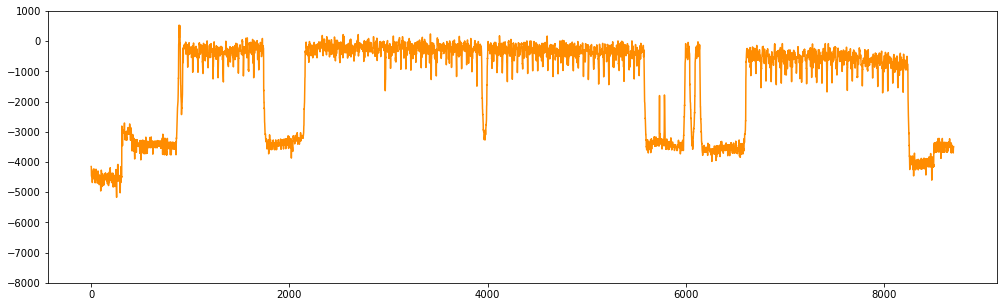

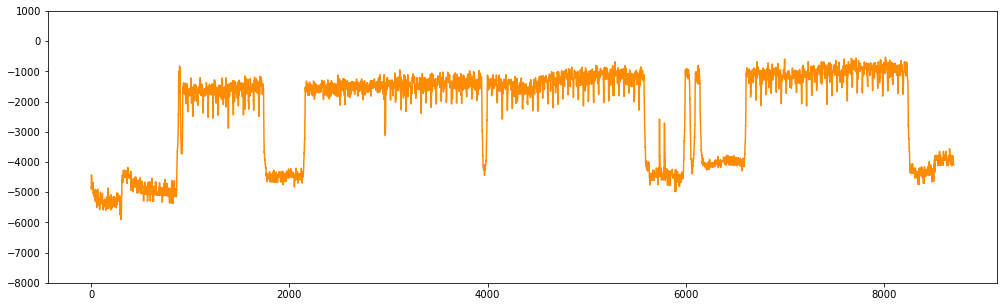

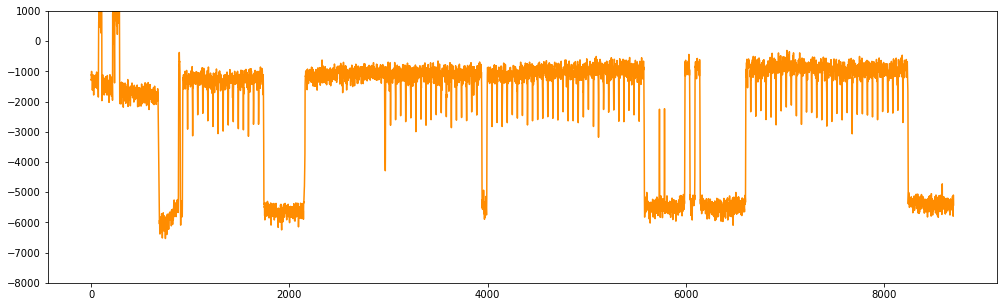

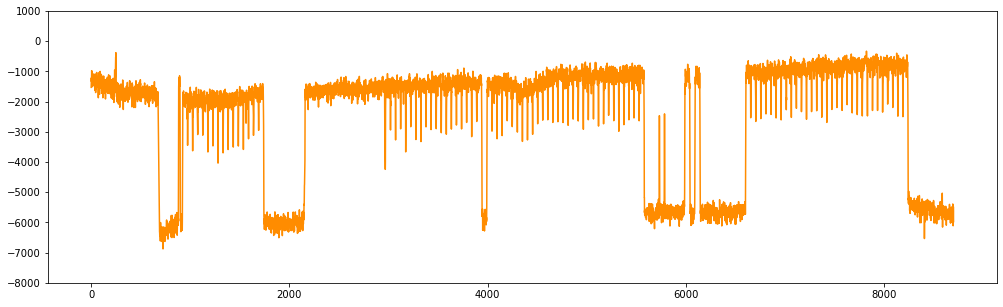

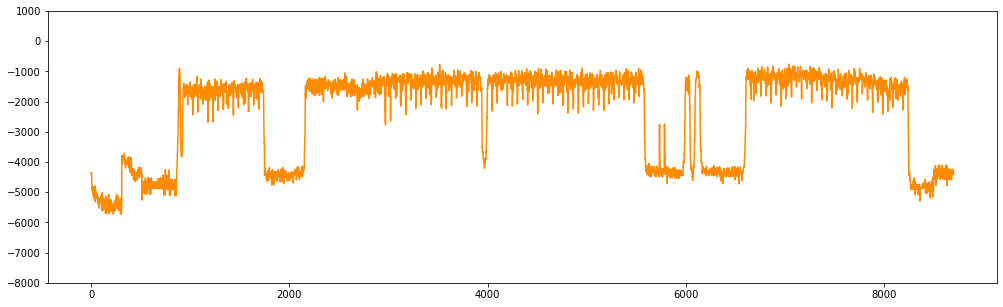

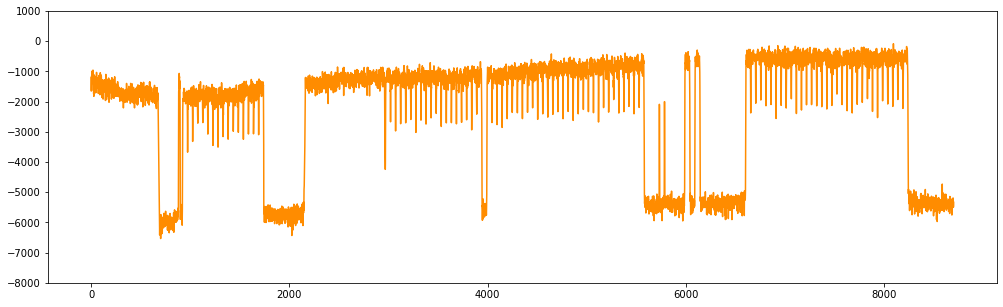

In [19]:
def plot_amps_2(amps):
    for amp in amps:
        plt.figure(figsize=(17,5))
        plt.plot(amp, color='darkorange')
        plt.ylim(-8000,1000)
        plt.show()

plot_amps_2(df_3vac1_60_det['amplitudes'])

In [20]:
# Looking at the detected waveforms in the first 60 rows, it seems to be working
# Notches are detected as expected
# Applying to whole dataset...

#### Applying to Whole dataset

In [38]:
df_3vac1['notches_or_suckouts_detected'] = df_3vac1['amplitudes'].progress_apply(lambda x: match_candidate_dips_against_template(x, MIN_WINDOW_LENGTH_FOR_VALID_DIP), False)

  0%|          | 0/1046 [00:00<?, ?it/s]

In [41]:
df_3vac1

,device_id,amplitudes,above_0db_noise_detected,ingress_detected,notches_or_suckouts_detected
0,3c:04:61:fe:1e:81,"[-6262, -6033, -6128, -6434, -6424, -6254, -62...",0,0,0
1,58:19:f8:2a:ce:a7,"[-6612, -6627, -6640, -6914, -7127, -6670, -64...",0,0,0
2,a8:97:cd:41:0e:f1,"[-4500, -4510, -4660, -4710, -4710, -4870, -48...",0,0,0
3,b0:da:f9:3e:5d:c6,"[-4570, -4590, -4670, -4690, -4690, -4660, -46...",0,1,0
4,d4:04:cd:d6:f3:5d,"[-6678, -6531, -6430, -6245, -6531, -6476, -66...",0,0,0
...,...,...,...,...,...
1041,98:52:4a:07:80:ff,"[-1262, -1436, -1118, -1104, -1057, -1363, -11...",1,1,0
1042,98:f7:d7:b8:e6:f9,"[-5411, -5340, -5381, -5258, -5445, -5364, -52...",0,1,0
1043,08:a7:c0:a3:f0:ba,"[-1711, -1483, -1383, -1197, -985, -1064, -101...",0,1,0
1044,a8:97:cd:40:37:a5,"[-4720, -4740, -4880, -4920, -4920, -5030, -50...",0,0,0


In [43]:
df_3vac1.to_csv('Impairment Detection Results/3VAC1_result.csv', index=False)